In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from docopt import docopt
import os, os.path
import errno

from scipy.stats import loguniform
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    cross_val_predict
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc

from plot_confusion_matrix import plot_confusion_mat
from get_valid_score import mean_std_cross_val_scores

In [2]:
path = "../data/processed"
train_df = pd.read_csv(path+"/bank-additional-train.csv")
test_df = pd.read_csv(path+"/bank-additional-test.csv")

In [3]:
X_train = train_df.drop(columns=["y"])
X_test = test_df.drop(columns=["y"])

y_train = train_df["y"]
y_test = test_df["y"]

In [4]:
train_df.apply(lambda x: pd.unique(x).tolist())

age               [35, 22, 38, 25, 37, 30, 52, 33, 32, 39, 51, 4...
job               [entrepreneur, services, blue-collar, technici...
marital                        [married, single, divorced, unknown]
education         [high.school, professional.course, unknown, ba...
default                                          [no, unknown, yes]
housing                                          [no, yes, unknown]
loan                                             [no, yes, unknown]
contact                                       [telephone, cellular]
month             [may, jul, jun, aug, nov, apr, sep, oct, dec, ...
day_of_week                               [fri, tue, wed, thu, mon]
duration          [178, 256, 42, 442, 107, 1109, 873, 91, 367, 1...
campaign          [2, 3, 5, 4, 8, 1, 10, 6, 12, 13, 20, 11, 7, 2...
pdays             [999, 2, 6, 13, 12, 3, 14, 7, 4, 9, 11, 1, 0, ...
previous                                   [0, 1, 2, 3, 4, 7, 5, 6]
poutcome                            [nonexistent

In [5]:
numeric_features = [
    "age",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]

categorical_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]

binary_features = [
    "y",
]

drop_features = []
target = "y"

In [6]:
assert len(numeric_features+categorical_features) == len(X_train.columns)

In [7]:
numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler()
    )

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'duration', 'campaign', 'pdays',
                                  'previous', 'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m',
                                  'nr.employed']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                       

In [8]:
results = {}

In [9]:
scoring_metrics = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

#### Create Dummy Classifier

In [10]:
dummy = DummyClassifier()
pipe = make_pipeline(preprocessor, dummy)

results['dummy'] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring = scoring_metrics
)
pd.DataFrame(results).T

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precis

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
dummy,0.080 (+/- 0.005),0.020 (+/- 0.000),0.888 (+/- 0.000),0.888 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


#### Confusion Matrix from the Dummy Classifier

C:\MDS\Block 3\DSCI522\lab\Group\Bank_Marketing_Prediction\doc\plot_confusion_matrix.py:51: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = conf_mat[1,1] / sum(conf_mat[:,1])


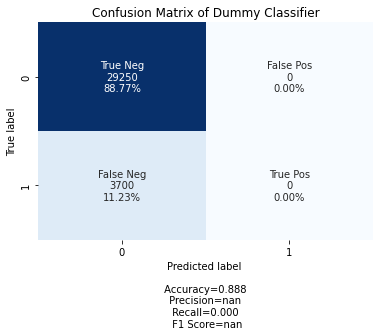

In [11]:
y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
plot_confusion_mat(y_train, y_pred, 'Dummy Classifier');

### RFC

#### Model building: Tuning Hyperparameters

In [12]:
param_grid = { 
    'RFC__max_features' : ["auto", "sqrt", "log2"],
    'RFC__min_samples_split' : range(1, 100),
    'RFC__max_depth' : range(1,5000),
    'RFC__class_weight' : ["balanced", "balanced_subsample"],
    'RFC__ccp_alpha' : 10**np.arange(-3,3, dtype=float),
}

pipe = Pipeline([
    ('preprocessor',preprocessor), 
    ('RFC',RandomForestClassifier(random_state=123, n_jobs=-1))
])

random_search_RFC = RandomizedSearchCV(estimator=pipe,
                                       param_distributions=param_grid,
                                       n_iter = 20,
                                       n_jobs = -1,
                                       random_state = 123,
                                       return_train_score = True,
                                       scoring = scoring_metrics,
                                       refit = 'f1',
                                      )
random_search_RFC.fit(X_train, y_train);

In [13]:
print("Best hyperparameter values: ", random_search_RFC.best_params_)
print(f"Best f1 score: {random_search_RFC.best_score_:0.3f}")

Best hyperparameter values:  {'RFC__min_samples_split': 88, 'RFC__max_features': 'sqrt', 'RFC__max_depth': 4179, 'RFC__class_weight': 'balanced', 'RFC__ccp_alpha': 0.001}
Best f1 score: 0.551


In [14]:
best_RFC_CV_results = pd.DataFrame(random_search_RFC.cv_results_)[[
'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params',
       'mean_train_accuracy','std_train_accuracy',
       'mean_train_f1', 'std_train_f1',
       'mean_train_recall', 'std_train_recall',
       'mean_train_precision', 'std_train_precision',
       'mean_test_accuracy','std_test_accuracy', 'rank_test_accuracy',
       'mean_test_f1','std_test_f1', 'rank_test_f1', 
       'mean_test_recall', 'std_test_recall','rank_test_recall', 
       'mean_test_precision','std_test_precision', 'rank_test_precision',
]].set_index("rank_test_f1").sort_index()
best_RFC_CV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_train_accuracy,std_train_accuracy,mean_train_f1,std_train_f1,mean_train_recall,...,std_test_accuracy,rank_test_accuracy,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
rank_test_f1,,,,,,,,,,,,,,,,,,,,,
1,4.698100,0.598074,0.901502,0.440506,"{'RFC__min_samples_split': 88, 'RFC__max_featu...",0.830766,0.001756,0.558214,0.002685,0.952095,...,0.004137,2,0.551348,0.006265,0.938919,0.009494,2,0.390293,0.005971,1
2,4.307600,0.851753,1.739102,0.601537,"{'RFC__min_samples_split': 80, 'RFC__max_featu...",0.829954,0.002209,0.557023,0.003026,0.952027,...,0.002997,3,0.550798,0.004078,0.940270,0.010585,1,0.389506,0.004054,3
3,3.256500,1.478924,1.436100,1.290031,"{'RFC__min_samples_split': 56, 'RFC__max_featu...",0.831214,0.002311,0.557912,0.002969,0.948378,...,0.003668,1,0.550274,0.005794,0.933243,0.008572,3,0.390190,0.005333,2
4,4.745500,0.568216,1.173003,0.631193,"{'RFC__min_samples_split': 47, 'RFC__max_featu...",0.802633,0.007519,0.511406,0.009075,0.919527,...,0.005020,4,0.507827,0.006090,0.914054,0.040618,6,0.351802,0.002679,4
5,3.960800,0.670498,2.068800,0.829010,"{'RFC__min_samples_split': 9, 'RFC__max_featur...",0.802178,0.007224,0.511788,0.006418,0.922905,...,0.010371,5,0.507443,0.010858,0.915676,0.026900,5,0.351206,0.010863,5
6,3.926902,1.585973,2.390501,1.179212,"{'RFC__min_samples_split': 16, 'RFC__max_featu...",0.797018,0.006468,0.508648,0.007584,0.935270,...,0.006557,6,0.505689,0.008437,0.926757,0.028066,4,0.347836,0.006917,6
7,3.542391,0.101643,2.218903,0.063513,"{'RFC__min_samples_split': 85, 'RFC__max_featu...",0.794970,0.007114,0.466926,0.017815,0.801824,...,0.009731,7,0.465216,0.011883,0.801351,0.069502,9,0.328492,0.005351,7
8,5.488099,0.124882,0.632301,0.013386,"{'RFC__min_samples_split': 64, 'RFC__max_featu...",0.747269,0.030642,0.440918,0.042843,0.880676,...,0.032807,8,0.439170,0.046777,0.879189,0.059322,7,0.293152,0.036568,8
9,4.572001,1.467401,1.766102,1.096832,"{'RFC__min_samples_split': 18, 'RFC__max_featu...",0.717284,0.016110,0.407319,0.021329,0.864662,...,0.018370,10,0.404782,0.021640,0.861081,0.054722,8,0.264794,0.015213,10


In [40]:
best_RFC_params = {key.replace('RFC__',''):val for (key, val) in random_search_RFC.best_params_.items()}
best_RFC_params['random_state']=123
best_RFC_params['n_jobs']=-1
pd.DataFrame(best_RFC_params, index=["Best"])

,min_samples_split,max_features,max_depth,class_weight,ccp_alpha,random_state,n_jobs
Best,88,sqrt,4179,balanced,0.001,123,-1


In [16]:
best_RFC = pipe = Pipeline([
    ('preprocessor',preprocessor), 
    ('RFC',RandomForestClassifier(**best_RFC_params))
])

best_RFC.fit(X_train, y_train)
best_RFC.score(X_train, y_train)

0.8272230652503794

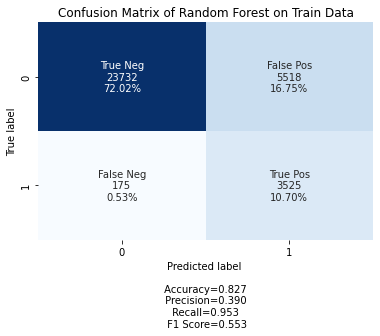

In [17]:
y_pred = best_RFC.predict(X_train)
plot_confusion_mat(y_train, y_pred,'Random Forest on Train Data');

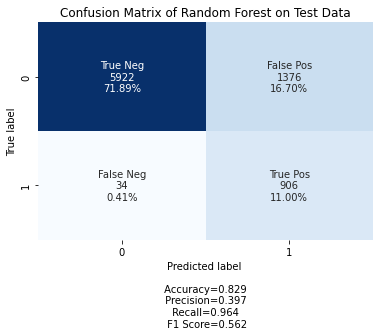

In [18]:
y_pred = best_RFC.predict(X_test)
plot_confusion_mat(y_test, y_pred,'Random Forest on Test Data');

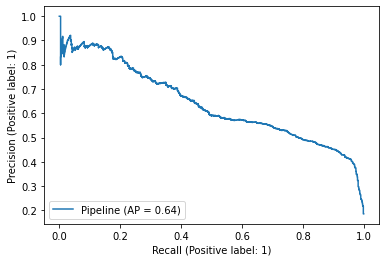

In [19]:
PrecisionRecallDisplay.from_estimator(best_RFC, X_test, y_test);

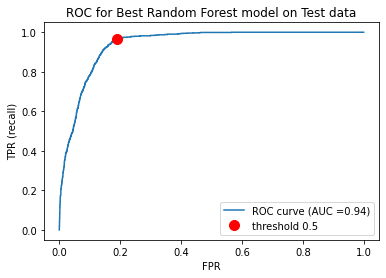

In [20]:
y_pred = best_RFC.predict_proba(X_test)[:,1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (AUC ={0:.2f})'.format(roc_auc))
plt.title("ROC for Best Random Forest model on Test data")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

### LR

#### Model building: Tuning Hyperparameters

In [21]:
param_grid = { 
    #'LR__C' : np.linspace(1,50,100),
    'LR__C' : loguniform(1e-3, 50),
    'LR__class_weight' : ["balanced", None],
}

pipe_lr = Pipeline([
    ('preprocessor',preprocessor), 
    ('LR',LogisticRegression(max_iter=1000, random_state=123))
])

random_search_LR = RandomizedSearchCV(estimator=pipe_lr,
                                       param_distributions=param_grid,
                                       n_iter = 100,
                                       n_jobs = -1,
                                       random_state = 123,
                                       return_train_score = True,
                                       scoring = scoring_metrics,
                                       refit = 'f1',
                                      )
random_search_LR.fit(X_train, y_train);

In [22]:
print("Best hyperparameter values: ", random_search_LR.best_params_)
print(f"Best f1 score: {random_search_LR.best_score_:0.3f}")

Best hyperparameter values:  {'LR__C': 3.3999927015362434, 'LR__class_weight': 'balanced'}
Best f1 score: 0.585


In [23]:
best_LR_CV_results = pd.DataFrame(random_search_LR.cv_results_)[[
'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params',
       'mean_train_accuracy','std_train_accuracy',
       'mean_train_f1', 'std_train_f1',
       'mean_train_recall', 'std_train_recall',
       'mean_train_precision', 'std_train_precision',
       'mean_test_accuracy','std_test_accuracy', 'rank_test_accuracy',
       'mean_test_f1','std_test_f1', 'rank_test_f1', 
       'mean_test_recall', 'std_test_recall','rank_test_recall', 
       'mean_test_precision','std_test_precision', 'rank_test_precision',
]].set_index("rank_test_f1").sort_index()
best_LR_CV_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_train_accuracy,std_train_accuracy,mean_train_f1,std_train_f1,mean_train_recall,...,std_test_accuracy,rank_test_accuracy,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
rank_test_f1,,,,,,,,,,,,,,,,,,,,,
1,7.650999,3.364807,0.095400,0.053088,"{'LR__C': 3.3999927015362434, 'LR__class_weigh...",0.860129,0.001182,0.586989,0.002303,0.885135,...,0.005340,53,0.584718,0.010424,0.881351,0.014739,1,0.437573,0.010231,53
2,4.829396,1.531815,0.068408,0.005736,"{'LR__C': 40.60519023862296, 'LR__class_weight...",0.860212,0.001243,0.587153,0.002427,0.885203,...,0.005398,54,0.584670,0.010554,0.881351,0.014388,1,0.437517,0.010362,56
2,5.140909,1.123241,0.068091,0.004329,"{'LR__C': 21.01361947535864, 'LR__class_weight...",0.860220,0.001237,0.587166,0.002398,0.885203,...,0.005398,54,0.584670,0.010554,0.881351,0.014388,1,0.437517,0.010362,56
4,6.201699,2.537913,0.117802,0.088209,"{'LR__C': 3.8390374787015733, 'LR__class_weigh...",0.860144,0.001182,0.586997,0.002265,0.885068,...,0.005398,54,0.584668,0.010512,0.881351,0.014739,1,0.437519,0.010333,54
4,7.010200,1.955441,0.067699,0.004945,"{'LR__C': 3.0104438715421917, 'LR__class_weigh...",0.860137,0.001210,0.587003,0.002346,0.885135,...,0.005398,54,0.584668,0.010512,0.881351,0.014739,1,0.437519,0.010333,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.587997,0.255536,0.044101,0.013605,"{'LR__C': 0.015929357370078345, 'LR__class_wei...",0.910334,0.000707,0.500161,0.004776,0.399527,...,0.001566,44,0.496921,0.008293,0.397297,0.009669,96,0.663723,0.014637,3
97,1.649001,0.183630,0.069999,0.006541,"{'LR__C': 0.015027344733666409, 'LR__class_wei...",0.910303,0.000693,0.499442,0.004676,0.398514,...,0.001311,49,0.495721,0.007778,0.396216,0.009945,97,0.662478,0.012712,6
98,1.416401,0.041043,0.070599,0.003201,"{'LR__C': 0.011819580830227874, 'LR__class_wei...",0.909954,0.000704,0.495742,0.004822,0.394189,...,0.001004,50,0.493091,0.005340,0.392973,0.008391,98,0.662177,0.011659,7


In [24]:
pd.DataFrame(random_search_LR.cv_results_)['param_LR__class_weight']

0     balanced
1     balanced
2         None
3         None
4     balanced
        ...   
95    balanced
96        None
97        None
98    balanced
99        None
Name: param_LR__class_weight, Length: 100, dtype: object

Text(0.5, 1.0, 'Logistic Regression C vs Accuracy')

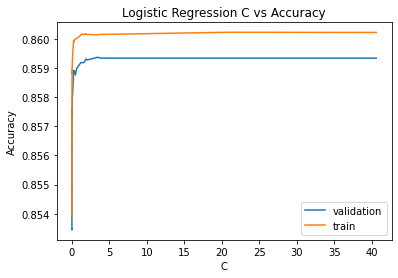

In [25]:
# Save C vs Accuracy plot
search_df = pd.DataFrame(random_search_LR.cv_results_).query("param_LR__class_weight=='balanced'").sort_values(by="param_LR__C", ascending=True)
plt.plot(search_df["param_LR__C"], search_df["mean_test_accuracy"], label="validation")
plt.plot(search_df["param_LR__C"], search_df["mean_train_accuracy"], label="train")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title('Logistic Regression C vs Accuracy')
#plt.savefig(dest+'/Log_Reg_C_vs_Accuracy.png')

Text(0.5, 1.0, 'Logistic Regression C vs F1')

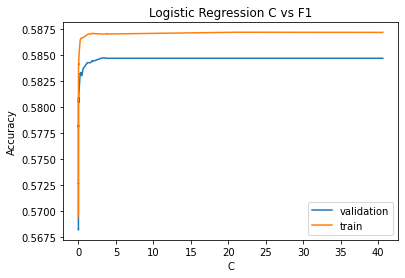

In [26]:
# Save C vs Accuracy plot
search_df = pd.DataFrame(random_search_LR.cv_results_).query("param_LR__class_weight=='balanced'").sort_values(by="param_LR__C", ascending=True)
plt.plot(search_df["param_LR__C"], search_df["mean_test_f1"], label="validation")
plt.plot(search_df["param_LR__C"], search_df["mean_train_f1"], label="train")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title('Logistic Regression C vs F1')
#plt.savefig(dest+'/Log_Reg_C_vs_Accuracy.png')

In [27]:
best_LR_params = {key.replace('LR__',''):val for (key, val) in random_search_LR.best_params_.items()}
best_LR_params['random_state']=123
best_LR_params['max_iter']=1000
best_LR_params

{'C': 3.3999927015362434,
 'class_weight': 'balanced',
 'random_state': 123,
 'max_iter': 1000}

In [28]:
best_LR = Pipeline([
    ('preprocessor',preprocessor), 
    ('LR',LogisticRegression(**best_LR_params))
])
best_LR.fit(X_train, y_train)
best_LR.score(X_train, y_train)

0.8600606980273141

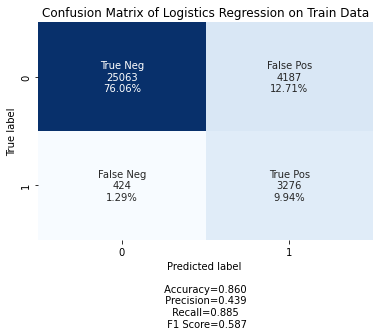

In [29]:
y_pred = best_LR.predict(X_train)
plot_confusion_mat(y_train, y_pred,'Logistics Regression on Train Data');

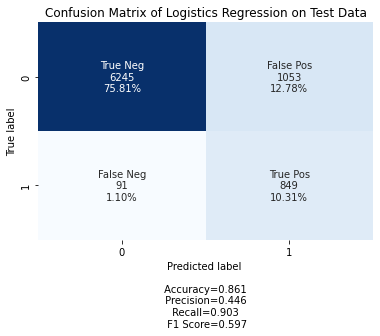

In [30]:
y_pred = best_LR.predict(X_test)
plot_confusion_mat(y_test, y_pred,'Logistics Regression on Test Data');

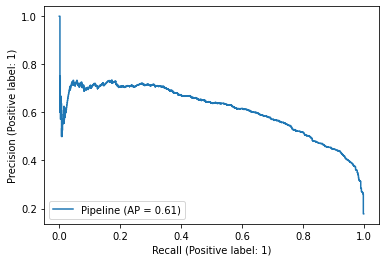

In [31]:
PrecisionRecallDisplay.from_estimator(best_LR, X_test, y_test);

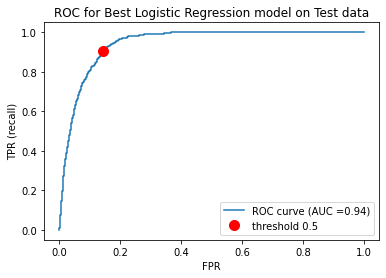

In [32]:
y_pred = best_LR.predict_proba(X_test)[:,1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (AUC ={0:.2f})'.format(roc_auc))
plt.title("ROC for Best Logistic Regression model on Test data")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [33]:
categorical_features_ohe = list(
    preprocessor.named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + categorical_features_ohe
)

In [34]:
lr_coefs = pd.DataFrame(data=best_LR[1].coef_[0], index=new_columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient", ascending=False).head(20)

,Coefficient
duration,1.802068
month_mar,1.801493
cons.price.idx,1.257304
euribor3m,1.237929
month_aug,0.869526
education_illiterate,0.707107
poutcome_success,0.410475
job_retired,0.387012
job_student,0.340018
default_no,0.231212
